In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext

appName = "Fifa_dataset"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Users\saisr\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from pyspark.sql.functions import lit
dfs = []
for year in range(15, 23):
    file_path = f'players_{year}.csv'
    df = spark.read.csv(file_path, header= True, inferSchema = True)
    df = df.withColumn("year", lit(year))
    print(df.count())
    dfs.append(df)
    
df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.union(df)

print(df_final.count() )

16155
15623
17596
17954
18085
18483
18944
19239
142079


In [3]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="SaiSravan@12"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "fifa.Fifa_Dataset"
#db_properties['Schemas'] = 'fifa'

df_final.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [4]:
# Reading back from postgres to make sure everything is working fine

df_final = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_final.show(1, vertical=True)

-RECORD 0-------------------------------------------
 sofifa_id                   | 158023               
 player_url                  | https://sofifa.co... 
 short_name                  | L. Messi             
 long_name                   | Lionel Andrés Mes... 
 player_positions            | CF                   
 overall                     | 93                   
 potential                   | 95                   
 value_eur                   | 1.005E8              
 wage_eur                    | 550000.0             
 age                         | 27                   
 dob                         | 1987-06-24           
 height_cm                   | 169                  
 weight_kg                   | 67                   
 club_team_id                | 241.0                
 club_name                   | FC Barcelona         
 league_name                 | Spain Primera Div... 
 league_level                | 1                    
 club_position               | CF             

In [5]:
df_after_drop = df_final.drop('sofifa_id', 'player_url', 'short_name', 'long_name', 'player_positions', 'dob', 'club_name', 'league_name',
                'wage_eur', 'club_jersey_number', 'club_loaned_from', 'club_joined', 'club_contract_valid_until', 'nationality_name',
                'nation_team_id', 'nation_position', 'nation_jersey_number', 'work_rate', 'body_type', 'real_face', 'release_clause',
                'player_tags', 'player_traits', 'mentality_composure', 'goalkeeping_speed', 'player_face_url', 'club_logo_url',
                             'club_flag_url', 'nation_logo_url', 'nation_flag_url', 'release_clause_eur', 'year')

df_after_drop.show(1, vertical=True)

-RECORD 0------------------------------
 overall                     | 93      
 potential                   | 95      
 value_eur                   | 1.005E8 
 age                         | 27      
 height_cm                   | 169     
 weight_kg                   | 67      
 club_team_id                | 241.0   
 league_level                | 1       
 club_position               | CF      
 nationality_id              | 52      
 preferred_foot              | Left    
 weak_foot                   | 3       
 skill_moves                 | 4       
 international_reputation    | 5       
 pace                        | 93      
 shooting                    | 89      
 passing                     | 86      
 dribbling                   | 96      
 defending                   | 27      
 physic                      | 63      
 attacking_crossing          | 84      
 attacking_finishing         | 94      
 attacking_heading_accuracy  | 71      
 attacking_short_passing     | 89      


In [6]:
from pyspark.sql.functions import *

null_counts_df = df_after_drop.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_after_drop.columns])
null_counts_df.show(truncate=False, vertical=True)

-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 value_eur                   | 1897  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 club_team_id                | 1630  
 league_level                | 2015  
 club_position               | 1630  
 nationality_id              | 0     
 preferred_foot              | 0     
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_short_passing     | 0     
 attacking_volleys           | 0     
 skill_dribb

In [7]:
#dropping rows shown below and check again for the number of null values
columns_to_check = ["pace", "shooting", "passing", "dribbling", "defending", "physic", "club_team_id", "league_level"]
df_with_na_dropped_rows = df_after_drop.na.drop(subset = columns_to_check)

null_counts_df_after_rows_dropped = df_with_na_dropped_rows.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_with_na_dropped_rows.columns])
null_counts_df_after_rows_dropped.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 value_eur                   | 275 
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 club_position               | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                

In [8]:
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["value_eur"]
value_not_in_dataset = 0

# Replace None/Missing Value with a value that can't be present in the dataset.
df_without_imputation = df_with_na_dropped_rows.fillna(0, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_without_imputation).transform(df_without_imputation)
# we will drop the old column without imputation. We have only one column to be imputed
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])
# We will rename our newly imputed column with the correct name
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("value_eur_imputed","value_eur")

In [9]:
null_counts_df_after_rows_dropped = df_fully_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in df_fully_imputed.columns])
null_counts_df_after_rows_dropped.show(truncate=False, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 club_position               | 0   
 nationality_id              | 0   
 preferred_foot              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy          

In [10]:
df_fully_imputed.count()

124562

In [11]:
# Few values like "ls, st, rs lw, lf, cf, rf, rw, lam, cam, ram, lm, lcm, rcm, rm, lwb, ldm, \
#cdm, rdm, rwb, lb, lcb, cb, rcb, rb, gk" have ability + international reputation. As international reputation is already mentioned\
# We plan to remove international reputation and just keep the ability and store it as an integer.

columns_to_remove_plus = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]

for col_name in columns_to_remove_plus:
    df_fully_imputed = df_fully_imputed.withColumn(f"{col_name}_split", split(col(col_name), "\\+")[0])
    df_fully_imputed = df_fully_imputed.drop(col_name)
    df_fully_imputed = df_fully_imputed.withColumnRenamed(f"{col_name}_split", col_name)


In [12]:
# Summary 
df_fully_imputed.summary().show(truncate=False, vertical=True)

-RECORD 0-----------------------------------------
 summary                     | count              
 overall                     | 124562             
 potential                   | 124562             
 age                         | 124562             
 height_cm                   | 124562             
 weight_kg                   | 124562             
 club_team_id                | 124562             
 league_level                | 124562             
 club_position               | 124562             
 nationality_id              | 124562             
 preferred_foot              | 124562             
 weak_foot                   | 124562             
 skill_moves                 | 124562             
 international_reputation    | 124562             
 pace                        | 124562             
 shooting                    | 124562             
 passing                     | 124562             
 dribbling                   | 124562             
 defending                   | 

In [13]:
# get all the data types
df_fully_imputed.dtypes

[('overall', 'int'),
 ('potential', 'int'),
 ('age', 'int'),
 ('height_cm', 'int'),
 ('weight_kg', 'int'),
 ('club_team_id', 'double'),
 ('league_level', 'int'),
 ('club_position', 'string'),
 ('nationality_id', 'int'),
 ('preferred_foot', 'string'),
 ('weak_foot', 'int'),
 ('skill_moves', 'int'),
 ('international_reputation', 'int'),
 ('pace', 'int'),
 ('shooting', 'int'),
 ('passing', 'int'),
 ('dribbling', 'int'),
 ('defending', 'int'),
 ('physic', 'int'),
 ('attacking_crossing', 'int'),
 ('attacking_finishing', 'int'),
 ('attacking_heading_accuracy', 'int'),
 ('attacking_short_passing', 'int'),
 ('attacking_volleys', 'int'),
 ('skill_dribbling', 'int'),
 ('skill_curve', 'int'),
 ('skill_fk_accuracy', 'int'),
 ('skill_long_passing', 'int'),
 ('skill_ball_control', 'int'),
 ('movement_acceleration', 'int'),
 ('movement_sprint_speed', 'int'),
 ('movement_agility', 'int'),
 ('movement_reactions', 'int'),
 ('movement_balance', 'int'),
 ('power_shot_power', 'int'),
 ('power_jumping', 'in

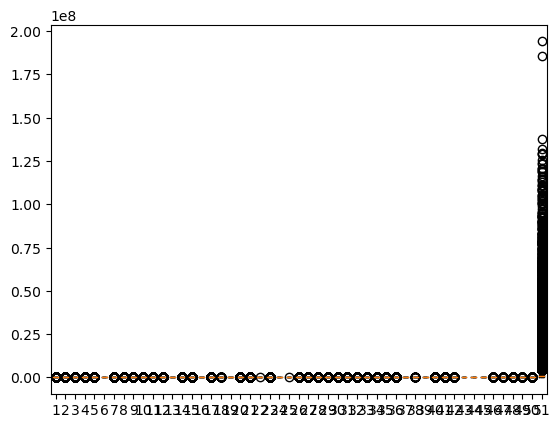

In [14]:
import matplotlib.pyplot as plt
numeric_features = [feature[0] for feature in df_fully_imputed.dtypes if feature[1] in ('int','double')]
#Extract data and convert them into Pandas for visualization
converted_data = df_fully_imputed[numeric_features].toPandas()
figure = plt.boxplot(converted_data)

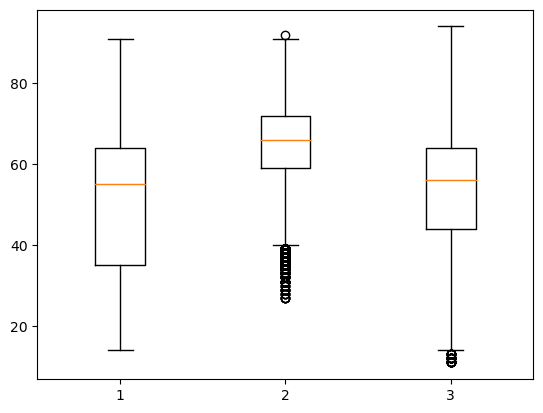

In [15]:
spotted_data = df_fully_imputed[numeric_features[15:18]].toPandas()
figure_subset = plt.boxplot(spotted_data)

In [16]:
figure_subset.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

In [17]:
# Values printed as comma separated Q1, Q3 for each object.
[item.get_ydata()[1] for item in figure_subset['whiskers']]

[14.0, 91.0, 40.0, 91.0, 14.0, 94.0]

In [18]:
# how to print outliers?!
[item.get_ydata() for item in figure_subset['fliers']]

[array([], dtype=int32),
 array([39, 38, 39, ..., 34, 39, 92]),
 array([11, 12, 13, 12, 12, 13, 12, 11, 12, 13, 13, 12, 11, 11, 13, 12, 13,
        11, 12, 12, 12, 12, 11, 13, 12, 11, 11, 13, 11, 12, 12, 12, 12, 12,
        13, 12, 11, 11, 11, 11, 12, 11, 13, 11, 11, 11, 11, 12])]

In [19]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [20]:
numeric_columns = [column[0] for column in df_fully_imputed.dtypes if column[1] in ('int','double')]
df_fully_imputed.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns]).show(1, vertical=True)

-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 club_team_id                | 0   
 league_level                | 0   
 nationality_id              | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_short_passing     | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control         

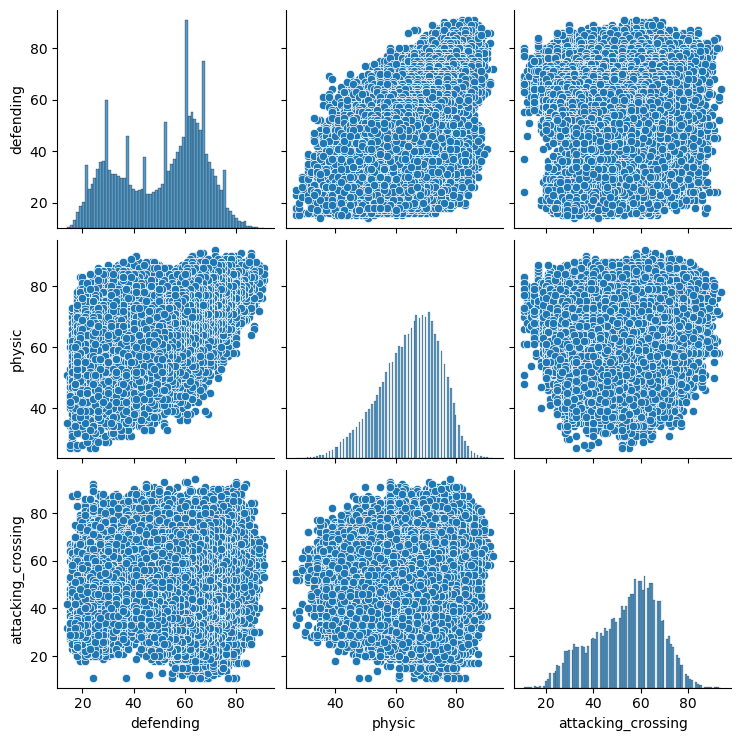

In [21]:
import seaborn as sb
sb.pairplot(spotted_data)

## Correlations

In [22]:
correlation_matrix = df_fully_imputed.toPandas().corr()
print(correlation_matrix)

C:\Users\saisr\AppData\Local\Temp\ipykernel_26224\613607425.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_fully_imputed.toPandas().corr()


                              overall  potential       age  height_cm  \
overall                      1.000000   0.692426  0.458722   0.068262   
potential                    0.692426   1.000000 -0.208002   0.025373   
age                          0.458722  -0.208002  1.000000   0.066461   
height_cm                    0.068262   0.025373  0.066461   1.000000   
weight_kg                    0.163092   0.009470  0.211422   0.747324   
club_team_id                -0.173239  -0.259153  0.086155  -0.120186   
league_level                -0.231041  -0.201822 -0.055791   0.066584   
nationality_id              -0.079357  -0.150573  0.058506  -0.139162   
weak_foot                    0.218669   0.156165  0.107816  -0.098477   
skill_moves                  0.391366   0.323694  0.099830  -0.275065   
international_reputation     0.492937   0.370354  0.259211   0.046251   
pace                         0.188422   0.265912 -0.200288  -0.411352   
shooting                     0.483123   0.320738  0

In [23]:
# checking which has a value more than 0.9 to remove redundant features
threshold = 0.9
high_correlation_points = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1,correlation_matrix.shape[0]):
        if np.abs(correlation_matrix.iloc[i,j])>threshold:
            
            high_correlation_points.append([correlation_matrix.columns[i], correlation_matrix.columns[j]])
for points in high_correlation_points:
    print(points)

['pace', 'movement_acceleration']
['pace', 'movement_sprint_speed']
['shooting', 'attacking_finishing']
['shooting', 'power_long_shots']
['passing', 'attacking_short_passing']
['dribbling', 'skill_dribbling']
['dribbling', 'skill_ball_control']
['defending', 'mentality_interceptions']
['defending', 'defending_marking_awareness']
['defending', 'defending_standing_tackle']
['defending', 'defending_sliding_tackle']
['mentality_interceptions', 'defending_standing_tackle']
['mentality_interceptions', 'defending_sliding_tackle']
['defending_marking_awareness', 'defending_standing_tackle']
['defending_marking_awareness', 'defending_sliding_tackle']
['defending_standing_tackle', 'defending_sliding_tackle']


In [24]:
df_after_corr = df_fully_imputed.drop('movement_acceleration', 'movement_sprint_speed', 'attacking_finishing',
                                     'power_long_shots', 'attacking_short_passing', 'skill_dribbling', 'skill_ball_control',
                                     'mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle',
                                     'defending_sliding_tackle')
df_after_corr.show(vertical = True)

-RECORD 0-----------------------------
 overall                    | 93      
 potential                  | 95      
 age                        | 27      
 height_cm                  | 169     
 weight_kg                  | 67      
 club_team_id               | 241.0   
 league_level               | 1       
 club_position              | CF      
 nationality_id             | 52      
 preferred_foot             | Left    
 weak_foot                  | 3       
 skill_moves                | 4       
 international_reputation   | 5       
 pace                       | 93      
 shooting                   | 89      
 passing                    | 86      
 dribbling                  | 96      
 defending                  | 27      
 physic                     | 63      
 attacking_crossing         | 84      
 attacking_heading_accuracy | 71      
 attacking_volleys          | 85      
 skill_curve                | 89      
 skill_fk_accuracy          | 90      
 skill_long_passing      

In [25]:
#handling binary variables. Like preferred foot... Left =1; Right =0
df_after_corr = df_after_corr.withColumn("preferred_foot", when(col("preferred_foot") == "Left", 1).otherwise(0))

#the last few columns like columns_to_remove_plus = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", 
#"cam", "ram", "lm", "lcm", "rcm", "rm", "lwb", "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
# are strings typecast into integers.
columns_to_cast = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
for col_name in columns_to_cast:
    df_after_corr = df_after_corr.withColumn(col_name, col(col_name).cast("int"))
df_after_corr.printSchema()

root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: double (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- club_position: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |-- preferred_foot: integer (nullable = false)
 |-- weak_foot: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- international_reputation: integer (nullable = true)
 |-- pace: integer (nullable = true)
 |-- shooting: integer (nullable = true)
 |-- passing: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- defending: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- attacking_crossing: integer (nullable = true)
 |-- attacking_heading_accuracy: integer (nullable = true)
 |-- attacking_volleys: integer (nullable = true)
 |-- skill_curve: in

In [26]:
from pyspark.sql.functions import col, sum

# Assuming df is your DataFrame
# Check for missing values in each column
missing_values = df_after_corr.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_after_corr.columns])

# Show the results
missing_values.show(vertical=True)

-RECORD 0--------------------------
 overall                    | 0    
 potential                  | 0    
 age                        | 0    
 height_cm                  | 0    
 weight_kg                  | 0    
 club_team_id               | 0    
 league_level               | 0    
 club_position              | 0    
 nationality_id             | 0    
 preferred_foot             | 0    
 weak_foot                  | 0    
 skill_moves                | 0    
 international_reputation   | 0    
 pace                       | 0    
 shooting                   | 0    
 passing                    | 0    
 dribbling                  | 0    
 defending                  | 0    
 physic                     | 0    
 attacking_crossing         | 0    
 attacking_heading_accuracy | 0    
 attacking_volleys          | 0    
 skill_curve                | 0    
 skill_fk_accuracy          | 0    
 skill_long_passing         | 0    
 movement_agility           | 0    
 movement_reactions         

In [27]:
columns_to_check = ["ls", "st", "rs", "lw", "lf", "cf", "rf", "rw", "lam", "cam", "ram", "lm", "lcm", "rcm", "rm", "lwb",
          "ldm", "cdm", "rdm", "rwb", "lb", "lcb", "cb", "rcb", "rb", "gk", "cm"]
df_after_corr = df_after_corr.na.drop(subset = columns_to_check)
df_after_corr.show(1, vertical=True)

-RECORD 0-----------------------------
 overall                    | 93      
 potential                  | 95      
 age                        | 27      
 height_cm                  | 169     
 weight_kg                  | 67      
 club_team_id               | 241.0   
 league_level               | 1       
 club_position              | CF      
 nationality_id             | 52      
 preferred_foot             | 1       
 weak_foot                  | 3       
 skill_moves                | 4       
 international_reputation   | 5       
 pace                       | 93      
 shooting                   | 89      
 passing                    | 86      
 dribbling                  | 96      
 defending                  | 27      
 physic                     | 63      
 attacking_crossing         | 84      
 attacking_heading_accuracy | 71      
 attacking_volleys          | 85      
 skill_curve                | 89      
 skill_fk_accuracy          | 90      
 skill_long_passing      

In [28]:
from pyspark.sql.functions import col, sum

# Assuming df is your DataFrame
# Check for missing values in each column
missing_values = df_after_corr.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_after_corr.columns])

# Show the results
missing_values.show(vertical=True)

-RECORD 0-------------------------
 overall                    | 0   
 potential                  | 0   
 age                        | 0   
 height_cm                  | 0   
 weight_kg                  | 0   
 club_team_id               | 0   
 league_level               | 0   
 club_position              | 0   
 nationality_id             | 0   
 preferred_foot             | 0   
 weak_foot                  | 0   
 skill_moves                | 0   
 international_reputation   | 0   
 pace                       | 0   
 shooting                   | 0   
 passing                    | 0   
 dribbling                  | 0   
 defending                  | 0   
 physic                     | 0   
 attacking_crossing         | 0   
 attacking_heading_accuracy | 0   
 attacking_volleys          | 0   
 skill_curve                | 0   
 skill_fk_accuracy          | 0   
 skill_long_passing         | 0   
 movement_agility           | 0   
 movement_reactions         | 0   
 movement_balance   

In [29]:
df_with_handled_binary = df_after_corr
#We handled the binary values in the above cell

In [30]:
#do string indexing for club_positions

from pyspark.ml import Transformer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stage_1 = StringIndexer(inputCol= 'club_position', outputCol= 'club_position_index')
#stage_2= OneHotEncoder(inputCols=['club_position_index'], outputCols=['club_position_encoded'])

pipeline = Pipeline(stages = [stage_1])
pipeline_model = pipeline.fit(df_with_handled_binary)
df_encoded = pipeline_model.transform(df_with_handled_binary)

In [31]:
#check if one hot encoding is properly done and view output

print(df_encoded.select("club_position").distinct().count())
df_encoded.select("club_position","club_position_index")\
                .distinct().toPandas()

28


,club_position,club_position_index
0,LW,16.0
1,LWB,22.0
2,RM,8.0
3,RS,15.0
4,ST,6.0
5,CB,19.0
6,LS,14.0
7,RW,17.0
8,LCB,3.0
9,LF,25.0


In [32]:
feature_list = df_encoded.drop('club_position', 'overall')
feature_list.show(1, vertical=True)

-RECORD 0-----------------------------
 potential                  | 95      
 age                        | 27      
 height_cm                  | 169     
 weight_kg                  | 67      
 club_team_id               | 241.0   
 league_level               | 1       
 nationality_id             | 52      
 preferred_foot             | 1       
 weak_foot                  | 3       
 skill_moves                | 4       
 international_reputation   | 5       
 pace                       | 93      
 shooting                   | 89      
 passing                    | 86      
 dribbling                  | 96      
 defending                  | 27      
 physic                     | 63      
 attacking_crossing         | 84      
 attacking_heading_accuracy | 71      
 attacking_volleys          | 85      
 skill_curve                | 89      
 skill_fk_accuracy          | 90      
 skill_long_passing         | 76      
 movement_agility           | 94      
 movement_reactions      

In [33]:
print(feature_list.columns)

['potential', 'age', 'height_cm', 'weight_kg', 'club_team_id', 'league_level', 'nationality_id', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_heading_accuracy', 'attacking_volleys', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'mentality_aggression', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes', 'value_eur', 'ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk', 'cm', 'club_position_index']


In [34]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(
    inputCols=feature_list.columns, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(df_encoded)

In [35]:
df_with_assembled_features.select("vectorized_features").show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|vectorized_features                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
df_with_assembled_features.show(3, vertical=True)

-RECORD 0------------------------------------------
 overall                    | 93                   
 potential                  | 95                   
 age                        | 27                   
 height_cm                  | 169                  
 weight_kg                  | 67                   
 club_team_id               | 241.0                
 league_level               | 1                    
 club_position              | CF                   
 nationality_id             | 52                   
 preferred_foot             | 1                    
 weak_foot                  | 3                    
 skill_moves                | 4                    
 international_reputation   | 5                    
 pace                       | 93                   
 shooting                   | 89                   
 passing                    | 86                   
 dribbling                  | 96                   
 defending                  | 27                   
 physic     

In [37]:
cols_to_keep = ['vectorized_features', 'overall']
features_list = df_with_assembled_features.select(*cols_to_keep)

In [38]:
features_list.show(vertical=True)

-RECORD 0-----------------------------------
 vectorized_features | [95.0,27.0,169.0,... 
 overall             | 93                   
-RECORD 1-----------------------------------
 vectorized_features | [92.0,29.0,185.0,... 
 overall             | 92                   
-RECORD 2-----------------------------------
 vectorized_features | [90.0,30.0,180.0,... 
 overall             | 90                   
-RECORD 3-----------------------------------
 vectorized_features | [90.0,32.0,195.0,... 
 overall             | 90                   
-RECORD 4-----------------------------------
 vectorized_features | [89.0,30.0,170.0,... 
 overall             | 89                   
-RECORD 5-----------------------------------
 vectorized_features | [91.0,27.0,181.0,... 
 overall             | 89                   
-RECORD 6-----------------------------------
 vectorized_features | [88.0,30.0,187.0,... 
 overall             | 88                   
-RECORD 7-----------------------------------
 vectorize

In [39]:
split = features_list.randomSplit([0.7, 0.3])
df_train = split[0]
df_test = split[1]

## Model - 1 - Linear Regression - SparkML

In [40]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall',
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(df_train)

In [41]:
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.4473960858455588,0.4067028223931021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7586268175730451,0.019026924711926914,0.001555602243996585,-0.0,0.0071432795366119595,0.011768638989213034,-0.0,0.030258676629684792,0.0018720797607260312,0.04561575621081386,0.0,0.00025035652250452904,0.0,0.0009699233200245379,0.0,0.19932265965992438,0.0,0.0,0.0,0.006565842702461883,0.014137592508131383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3585154269159762e-08,0.013974866311592058,0.013974866311592058,0.013974866311592058,2.3316501553737617e-05,0.0017241401431114089,0.0017241401431114089,0.0017241401431114089,2.3316501564726053e-05,0.0,0.0,0.0,0.007739570154113611,0.010466379914246897,0.010466379914246897,0.007739570154128048,0.005715550829843795,0.006540698374723846,0.006540698374723846,0.006540698374723846,0.005715550829848991,0.010084051419267643,0.004243255530968479,0.004243255530968479,0.004243255530968479,0.010084051419261343,-0.0,0.01046637991423159,0.0]
Intercept: -6.7198927239340245


In [42]:
trainingSummary = lr_model.summary
print("Training MSE: %f" % trainingSummary.meanSquaredError)
print("Training r2: %f" % trainingSummary.r2)

Training MSE: 4.012225
Training r2: 0.918690


In [43]:
test_result = lr_model.evaluate(df_test)
print("Test MSE:", test_result.meanSquaredError)
print("Training r2: %f" % test_result.r2)

Test MSE: 4.028666362707185
Training r2: 0.919268


In [44]:
def plot_r2(gt, pred, title):
    plt.figure(figsize=[5,5])

    plt.scatter(gt, pred, marker= ".")
    plt.plot([-1000,1000], [-1000,1000],"r--")

    all = np.concatenate([gt, pred])
    plt.xlim(np.min(all), np.max(all))
    plt.ylim(np.min(all), np.max(all))
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    plt.show()

In [45]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_test_pandas = df_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array = np.array(df_x_test_pandas['overall'].values.tolist(), dtype=np.float32)

In [46]:
lr_predictions = lr_model.transform(df_test)
lr_predictions.show(2, vertical=True)

-RECORD 0-----------------------------------
 vectorized_features | [47.0,32.0,176.0,... 
 overall             | 47                   
 prediction          | 48.863574280807875   
-RECORD 1-----------------------------------
 vectorized_features | [49.0,22.0,180.0,... 
 overall             | 40                   
 prediction          | 43.28610489732299    
only showing top 2 rows



In [47]:
df_x_test_pred_pandas = lr_predictions.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array_pred = np.array(df_x_test_pred_pandas['prediction'].values.tolist(), dtype=np.float32)

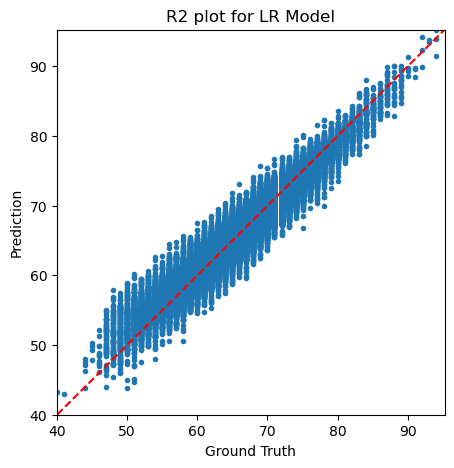

In [48]:
plot_r2(overall_array, overall_array_pred, 'R2 plot for LR Model')

In [49]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall')
lr_paramGrid = (ParamGridBuilder()
               .addGrid(lr.maxIter, [1,5])
               .addGrid(lr.regParam, [0.01, 0.3])
               .addGrid(lr.elasticNetParam, [0.9, 0.7])
               .build())

In [50]:
evaluator = RegressionEvaluator(labelCol='overall', metricName='mse')

In [51]:
lr_cv = CrossValidator(estimator = lr, estimatorParamMaps = lr_paramGrid, evaluator = evaluator, numFolds = 3)

In [52]:
'''lr_cv_model = lr_cv.fit(df_train)'''

'lr_cv_model = lr_cv.fit(df_train)'

In [53]:
lr_hyper1 = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall',
                      maxIter=20, regParam=0.5, elasticNetParam=0.2)
lr_hyper1_model = lr_hyper1.fit(df_train)
trainingSummary = lr_hyper1_model.summary
print("Training MSE hyper1: %f" % trainingSummary.meanSquaredError)
print("Training r2 hyper1: %f" % trainingSummary.r2)
test_result = lr_hyper1_model.evaluate(df_test)
print("Test MSE hyper1:", test_result.meanSquaredError)
print("Training r2 hyper1: %f" % test_result.r2)

Training MSE hyper1: 3.724333
Training r2 hyper1: 0.924524
Test MSE hyper1: 3.7184646511711077
Training r2 hyper1: 0.925484


In [54]:
lr_hyper2 = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall',
                      maxIter=100, regParam=0.85, elasticNetParam=0.1)
lr_hyper2_model = lr_hyper2.fit(df_train)
trainingSummary = lr_hyper2_model.summary
print("Training MSE hyper2: %f" % trainingSummary.meanSquaredError)
print("Training r2 hyper2: %f" % trainingSummary.r2)
test_result = lr_hyper2_model.evaluate(df_test)
print("Test MSE hyper2:", test_result.meanSquaredError)
print("Training r2 hyper2: %f" % test_result.r2)

Training MSE hyper2: 3.926738
Training r2 hyper2: 0.920422
Test MSE hyper2: 3.9140029814657407
Training r2 hyper2: 0.921566


In [55]:
lr_hyper3 = LinearRegression(featuresCol = 'vectorized_features', labelCol='overall',
                      maxIter=100, regParam=0.85, elasticNetParam=0.9)
lr_hyper3_model = lr_hyper3.fit(df_train)
trainingSummary = lr_hyper3_model.summary
print("Training MSE hyper3: %f" % trainingSummary.meanSquaredError)
print("Training r2 hyper3: %f" % trainingSummary.r2)
test_result = lr_hyper3_model.evaluate(df_test)
print("Test MSE hyper3:", test_result.meanSquaredError)
print("Training r2 hyper3: %f" % test_result.r2)

Training MSE hyper3: 5.699045
Training r2 hyper3: 0.884506
Test MSE hyper3: 5.696052737271359
Training r2 hyper3: 0.885854


The best hyperparameter tuning results came in 'hyper1' tuning. The test MSE is 3.735850648897124

## Model - 2 - Gradient Boosted Regression

In [56]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'vectorized_features', labelCol = 'overall', maxDepth = 4, maxIter=10, stepSize = 0.2)
gbt_model = gbt.fit(df_train)

In [57]:
from pyspark.ml.evaluation import RegressionEvaluator


gbt_predictions_train = gbt_model.transform(df_train)
gbt_evaluator_mse = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_train = gbt_evaluator_mse.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse_train)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_train = gbt_evaluator_r2.evaluate(gbt_predictions_train)
print("R2 on train data = %g" % r2_train)

Mean Squared Error (MSE) on train data = 2.42919
R2 on train data = 0.950771


In [58]:
gbt_predictions_test = gbt_model.transform(df_test)
gbt_evaluator = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_test = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse_test)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_test = gbt_evaluator_r2.evaluate(gbt_predictions_test)
print("R2 on test data = %g" % r2_test)

Mean Squared Error (MSE) on test data = 2.45902
R2 on test data = 0.950723


In [59]:
#training_data_hyperparam2
gbt_param2 = GBTRegressor(featuresCol = 'vectorized_features', labelCol = 'overall', maxDepth = 2, maxIter=5, stepSize = 0.6)
gbt_param2_model = gbt_param2.fit(df_train)

gbt_predictions_train = gbt_param2_model.transform(df_train)
gbt_evaluator_mse = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_train = gbt_evaluator_mse.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse_train)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_train = gbt_evaluator_r2.evaluate(gbt_predictions_train)
print("R2 on train data = %g" % r2_train)

#testing_data
gbt_predictions_test = gbt_param2_model.transform(df_test)
gbt_evaluator = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_test = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse_test)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_test = gbt_evaluator_r2.evaluate(gbt_predictions_test)
print("R2 on test data = %g" % r2_test)

Mean Squared Error (MSE) on train data = 5.41063
R2 on train data = 0.890351
Mean Squared Error (MSE) on test data = 5.44585
R2 on test data = 0.890868


In [60]:
#training_data_hyperparam3
gbt_param3 = GBTRegressor(featuresCol = 'vectorized_features', labelCol = 'overall', maxDepth = 10, maxIter=20, stepSize = 0.1)
gbt_param3_model = gbt_param3.fit(df_train)

gbt_predictions_train = gbt_param3_model.transform(df_train)
gbt_evaluator_mse = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_train = gbt_evaluator_mse.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % mse_train)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_train = gbt_evaluator_r2.evaluate(gbt_predictions_train)
print("R2 on train data = %g" % r2_train)

#testing_data_hyperparam3
gbt_predictions_test = gbt_param3_model.transform(df_test)
gbt_evaluator = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="mse")
mse_test = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % mse_test)

gbt_evaluator_r2 = RegressionEvaluator(
    labelCol="overall", predictionCol="prediction", metricName="r2")
r2_test = gbt_evaluator_r2.evaluate(gbt_predictions_test)
print("R2 on test data = %g" % r2_test)

Mean Squared Error (MSE) on train data = 0.367278
R2 on train data = 0.992557
Mean Squared Error (MSE) on test data = 0.631715
R2 on test data = 0.987341


We have identified our last tuned model to be the best model of the compared to the other hyperparameter tuning we have performed. The test MSE was 0.637397

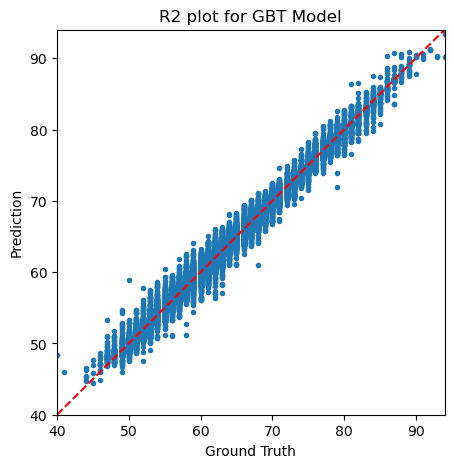

In [61]:
#best model r2

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_test_pandas = df_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array = np.array(df_x_test_pandas['overall'].values.tolist(), dtype=np.float32)

df_x_test_pred_pandas = gbt_predictions_test.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
overall_array_pred = np.array(df_x_test_pred_pandas['prediction'].values.tolist(), dtype=np.float32)

plot_r2(overall_array, overall_array_pred, 'R2 plot for GBT Model')

## Model - 3 - Pytorch - Shallow Network 

In [62]:
import torch
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np

to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
df_x_train_pandas = features_list.withColumn('vectorized_features', to_array('vectorized_features')).toPandas()
vectorized_features_array = np.array(df_x_train_pandas['vectorized_features'].values.tolist(), dtype=np.float32)
df_x_train = torch.from_numpy(vectorized_features_array)
overall_array = np.array(df_x_train_pandas['overall'].values.tolist(), dtype=np.float32)
df_y_train =  torch.from_numpy(overall_array)

In [63]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x)  # Assuming x is a NumPy array or a list
        self.y = torch.tensor(y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset_train = MyDataset(df_x_train, df_y_train)
train_dataset_len = len(dataset_train)
test_dataset_len = int(train_dataset_len*0.3)
train_dataset_len = train_dataset_len - test_dataset_len
train_dataset,test_dataset = torch.utils.data.random_split(dataset_train, [train_dataset_len, test_dataset_len])

C:\Users\saisr\AppData\Local\Temp\ipykernel_26224\2843416515.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x)  # Assuming x is a NumPy array or a list
C:\Users\saisr\AppData\Local\Temp\ipykernel_26224\2843416515.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


In [64]:
test_dataset_len = len(test_dataset)
validate_dataset_len = int(test_dataset_len*0.5)
test_dataset_len = test_dataset_len - validate_dataset_len
test_dataset,validate_dataset = torch.utils.data.random_split(test_dataset, [test_dataset_len, validate_dataset_len])

In [65]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
                        nn.Linear(in_features = vectorized_features_array.shape[1], out_features = 15),
                        nn.ReLU(),
                        nn.Linear(in_features = 15, out_features = 1),
                        )
    def forward(self, x):
        return self.layer_stack(x)

In [66]:
model1 = NeuralNetwork()
print(model1)

NeuralNetwork(
  (layer_stack): Sequential(
    (0): Linear(in_features=68, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=1, bias=True)
  )
)


In [67]:
from torch import optim
model1 = NeuralNetwork()
#hyper parameters iteration 1
lr = 0.1
batch_size = 16
N_epochs = 10
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
        
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss

Epoch = 0, train_loss = 4543439.0, validate_loss = 887.6680297851562
Best epoch
Epoch = 1, train_loss = 176.6995391845703, validate_loss = 49.608272552490234
Best epoch
Epoch = 2, train_loss = 49.55267333984375, validate_loss = 49.570518493652344
Best epoch
Epoch = 3, train_loss = 49.613616943359375, validate_loss = 49.6890869140625
Epoch = 4, train_loss = 49.62041091918945, validate_loss = 49.56611251831055
Best epoch
Epoch = 5, train_loss = 49.616737365722656, validate_loss = 49.601924896240234
Epoch = 6, train_loss = 49.615631103515625, validate_loss = 49.682037353515625
Epoch = 7, train_loss = 49.59418869018555, validate_loss = 49.70502853393555
Epoch = 8, train_loss = 49.61280822753906, validate_loss = 49.687442779541016
Epoch = 9, train_loss = 49.61795425415039, validate_loss = 49.57483673095703


(0.0, 100.0)

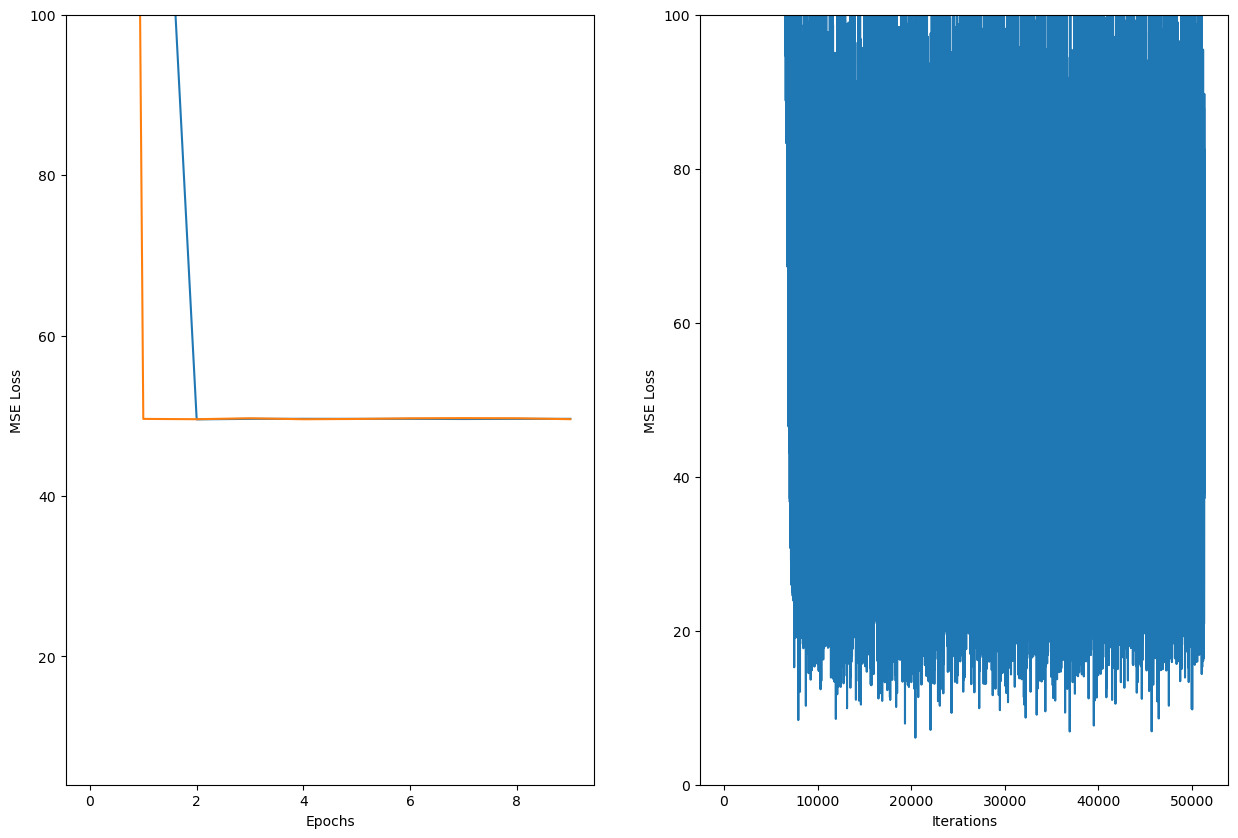

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(4, 100)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(0, 100)

In [81]:
from torch import optim
model1 = NeuralNetwork()
#hyper parameters iteration 2
lr = 0.01
batch_size = 64
N_epochs = 10
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
        
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch = 0, train_loss = 345295680.0, validate_loss = 4110.01806640625
Best epoch
Epoch = 1, train_loss = 301527.84375, validate_loss = 1833961.5
Epoch = 2, train_loss = 26879598.0, validate_loss = 4056.146728515625
Best epoch
Epoch = 3, train_loss = 3256.04052734375, validate_loss = 2494.98681640625
Best epoch
Epoch = 4, train_loss = 1969.453125, validate_loss = 1904.5784912109375
Best epoch
Epoch = 5, train_loss = 1299.1314697265625, validate_loss = 1120.701416015625
Best epoch
Epoch = 6, train_loss = 37251.4375, validate_loss = 1174.2701416015625
Epoch = 7, train_loss = 30987.673828125, validate_loss = 1066.822021484375
Best epoch
Epoch = 8, train_loss = 686.4724731445312, validate_loss = 319.8838806152344
Best epoch
Epoch = 9, train_loss = 194.02679443359375, validate_loss = 103.50799560546875
Best epoch


The gradient descent is moving in the right direction, but it ran out of epochs. So, the number of epochs are increased.

In [69]:
from torch import optim
model1 = NeuralNetwork()
#hyper parameters iteration 3
lr = 0.05
batch_size = 256
N_epochs = 100
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
        
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([197])) that is different to the input size (torch.Size([197, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([188])) that is different to the input size (torch.Size([188, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.

Epoch = 0, train_loss = 2743460608.0, validate_loss = 4942.984375
Best epoch
Epoch = 1, train_loss = 4544.10205078125, validate_loss = 4356.8359375
Best epoch
Epoch = 2, train_loss = 4255.2724609375, validate_loss = 4147.435546875
Best epoch
Epoch = 3, train_loss = 4081.987060546875, validate_loss = 3974.953369140625
Best epoch
Epoch = 4, train_loss = 3931.983642578125, validate_loss = 3843.1376953125
Best epoch
Epoch = 5, train_loss = 3825.422607421875, validate_loss = 3763.03466796875
Best epoch
Epoch = 6, train_loss = 3758.608642578125, validate_loss = 3711.451416015625
Best epoch
Epoch = 7, train_loss = 3714.3359375, validate_loss = 3673.806884765625
Best epoch
Epoch = 8, train_loss = 3674.572021484375, validate_loss = 3635.235595703125
Best epoch
Epoch = 9, train_loss = 3631.63427734375, validate_loss = 3590.748046875
Best epoch
Epoch = 10, train_loss = 3582.289794921875, validate_loss = 3536.729248046875
Best epoch
Epoch = 11, train_loss = 3525.520263671875, validate_loss = 3477.

Epoch = 99, train_loss = 49.53726577758789, validate_loss = 49.583961486816406


(0.0, 100.0)

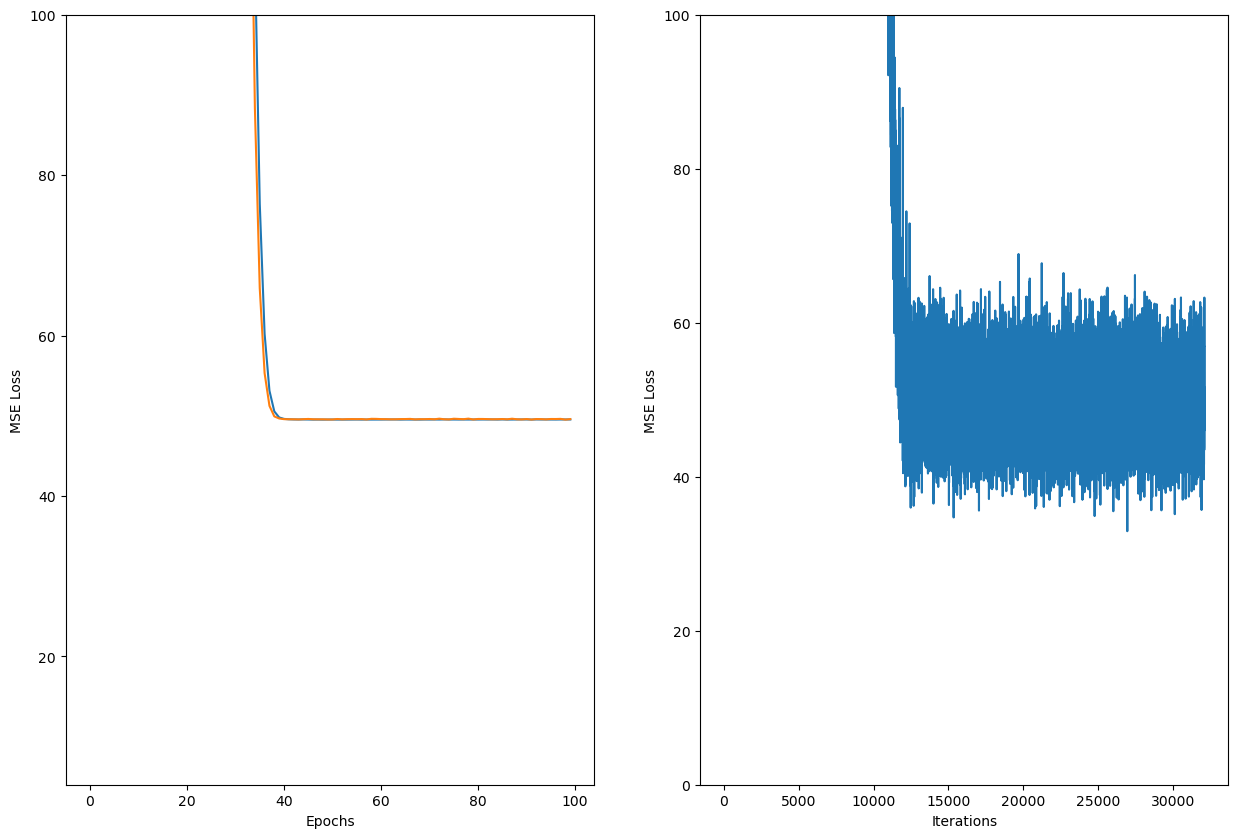

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(4, 100)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(0, 100)

In [71]:
mybestmodel  = NeuralNetwork()
test_batch_loss = []
lossfun = nn.MSELoss()
mybestmodel.load_state_dict(torch.load("current_best_model"))
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    loss = lossfun(prediction_score, y_batch) 
    test_batch_loss.append(loss.detach().numpy())
final_loss = (np.mean(np.array(test_batch_loss)))
print(f"Test MSE loss = {final_loss}")

Test MSE loss = 49.40304183959961


## Model - 4 - Pytorch - Deep Network

In [72]:
from torch import nn
class NeuralNetwork_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
                        nn.Linear(in_features = vectorized_features_array.shape[1], out_features = 128),
                        nn.ReLU(),
                        nn.Linear(in_features = 128, out_features = 256),
                        nn.ReLU(),
                        nn.Linear(in_features = 256, out_features = 256),
                        nn.ReLU(),
                        nn.Linear(in_features = 256, out_features = 128),
                        nn.ReLU(),
                        nn.Linear(in_features = 128, out_features = 64),
                        nn.ReLU(),
                        nn.Linear(in_features = 64, out_features = 32),
                        nn.ReLU(),
                        nn.Linear(in_features = 32, out_features = 1),
                        )
    def forward(self, x):
        return self.layer_stack(x)

In [73]:
model1 = NeuralNetwork_deep()
print(model1)

NeuralNetwork_deep(
  (layer_stack): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [74]:
from torch import optim
#hyper parameters iteration 1
lr = 0.1
batch_size = 16
N_epochs = 4
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

Epoch = 0, train_loss = 340609629945856.0, validate_loss = 4404.419921875
Best epoch
Epoch = 1, train_loss = 4403.87841796875, validate_loss = 4391.0029296875
Best epoch
Epoch = 2, train_loss = 4341.32080078125, validate_loss = 4218.5654296875
Best epoch
Epoch = 3, train_loss = 3635.263671875, validate_loss = 2508.999755859375
Best epoch


(2000.0, 5000.0)

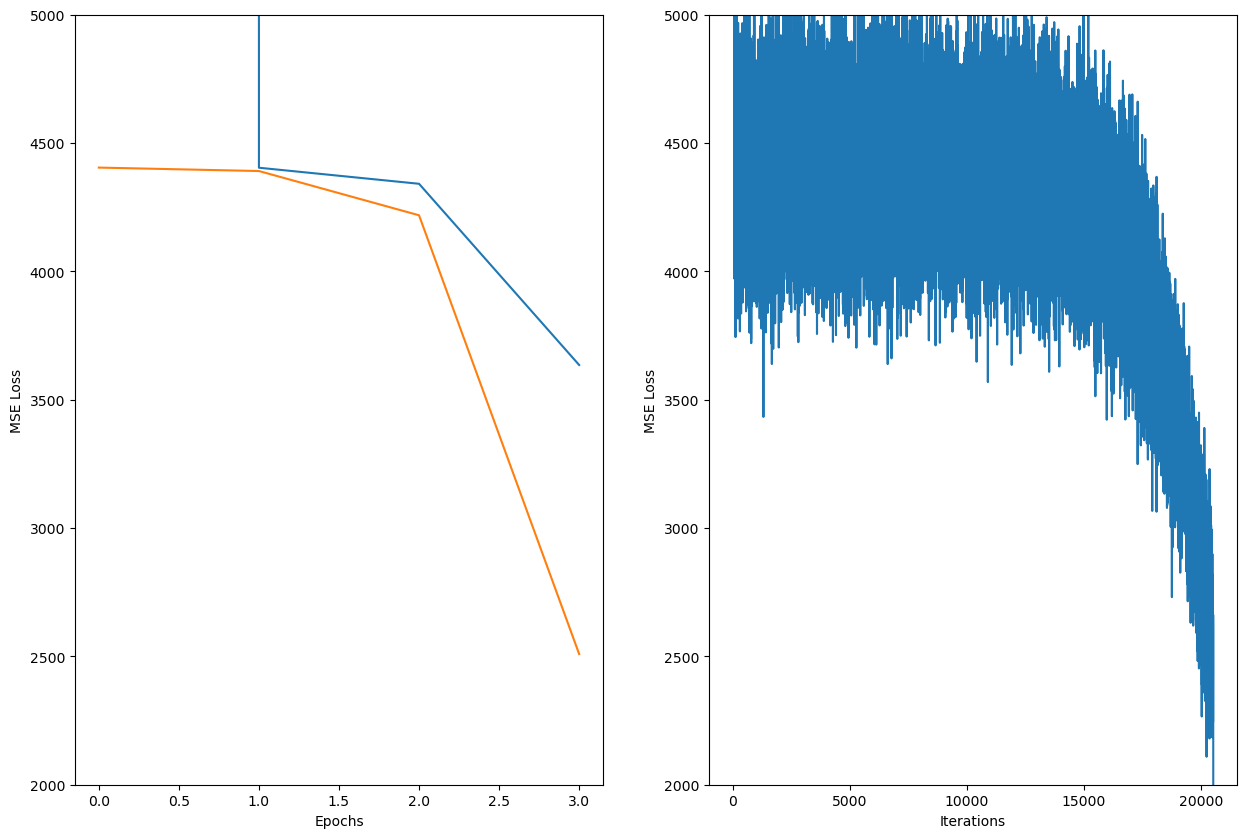

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(2000, 5000)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(2000, 5000)

In [76]:
from torch import optim
#hyper parameters iteration 2
lr = 0.001
batch_size = 128
N_epochs = 4
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([69])) that is different to the input size (torch.Size([69, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\saisr\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_

Epoch = 0, train_loss = 2480.0595703125, validate_loss = 2446.372802734375
Best epoch
Epoch = 1, train_loss = 2417.54052734375, validate_loss = 2384.2998046875
Best epoch
Epoch = 2, train_loss = 2355.964599609375, validate_loss = 2322.884765625
Best epoch
Epoch = 3, train_loss = 2295.680908203125, validate_loss = 2263.334716796875
Best epoch


In [77]:
from torch import optim
#hyper parameters iteration 3
lr = 0.001
batch_size = 128
N_epochs = 20
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

Epoch = 0, train_loss = 2235.74267578125, validate_loss = 2203.185791015625
Best epoch
Epoch = 1, train_loss = 2176.451171875, validate_loss = 2144.564453125
Best epoch
Epoch = 2, train_loss = 2118.337646484375, validate_loss = 2086.816650390625
Best epoch
Epoch = 3, train_loss = 2061.041015625, validate_loss = 2030.34375
Best epoch
Epoch = 4, train_loss = 2005.02099609375, validate_loss = 1974.31884765625
Best epoch
Epoch = 5, train_loss = 1949.5751953125, validate_loss = 1920.090576171875
Best epoch
Epoch = 6, train_loss = 1895.1717529296875, validate_loss = 1866.1904296875
Best epoch
Epoch = 7, train_loss = 1841.550048828125, validate_loss = 1812.656005859375
Best epoch
Epoch = 8, train_loss = 1788.830078125, validate_loss = 1760.3643798828125
Best epoch
Epoch = 9, train_loss = 1736.8194580078125, validate_loss = 1708.845947265625
Best epoch
Epoch = 10, train_loss = 1685.776123046875, validate_loss = 1658.5758056640625
Best epoch
Epoch = 11, train_loss = 1635.47314453125, validate_l

The learning rate is very small and thus the model is moving to the optimum solution, but it is going there very slowly. So the learning rate has been increased.

In [78]:
from torch import optim
#hyper parameters iteration 4
lr = 0.01
batch_size = 256
N_epochs = 20
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = lr)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)
losses = []

validate_losses = []
high_loss = np.inf

batch_loss_graph = []
#Training Loop
for epoch in range(N_epochs):
    batch_loss = []
    #training loop
    for x_batch, y_batch in train_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        batch_loss_graph.append(loss.detach().numpy())
    validate_batch_loss = []
    for x_batch, y_batch in validate_dataloader:
        prediction_score = model1(x_batch)
        loss = lossfun(prediction_score, y_batch)
        validate_batch_loss.append(loss.detach())
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))

    print(f"Epoch = {epoch}, train_loss = {losses[-1]}, validate_loss = {validate_losses[-1]}")

    if validate_losses[-1]<high_loss:
        print("Best epoch")
        torch.save(model1.state_dict(), 'current_best_model')
        high_loss = validate_losses[-1]

Epoch = 0, train_loss = 1134.6295166015625, validate_loss = 1031.4990234375
Best epoch
Epoch = 1, train_loss = 941.5936279296875, validate_loss = 852.2523803710938
Best epoch
Epoch = 2, train_loss = 774.8985595703125, validate_loss = 698.0695190429688
Best epoch
Epoch = 3, train_loss = 631.7988891601562, validate_loss = 566.181396484375
Best epoch
Epoch = 4, train_loss = 509.9208679199219, validate_loss = 454.4261779785156
Best epoch
Epoch = 5, train_loss = 407.2125244140625, validate_loss = 360.68402099609375
Best epoch
Epoch = 6, train_loss = 321.7029113769531, validate_loss = 283.3431396484375
Best epoch
Epoch = 7, train_loss = 251.6267547607422, validate_loss = 220.47738647460938
Best epoch
Epoch = 8, train_loss = 195.3036651611328, validate_loss = 170.66207885742188
Best epoch
Epoch = 9, train_loss = 151.06919860839844, validate_loss = 132.07064819335938
Best epoch
Epoch = 10, train_loss = 117.36786651611328, validate_loss = 103.22699737548828
Best epoch
Epoch = 11, train_loss = 9

In [79]:
mybestmodel  = NeuralNetwork_deep()
test_batch_loss = []
lossfun = nn.MSELoss()
mybestmodel.load_state_dict(torch.load("current_best_model"))
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    loss = lossfun(prediction_score, y_batch) 
    test_batch_loss.append(loss.detach().numpy())
final_loss = (np.mean(np.array(test_batch_loss)))
print(f"Test MSE loss = {final_loss}")

Test MSE loss = 49.44304656982422


(30.0, 600.0)

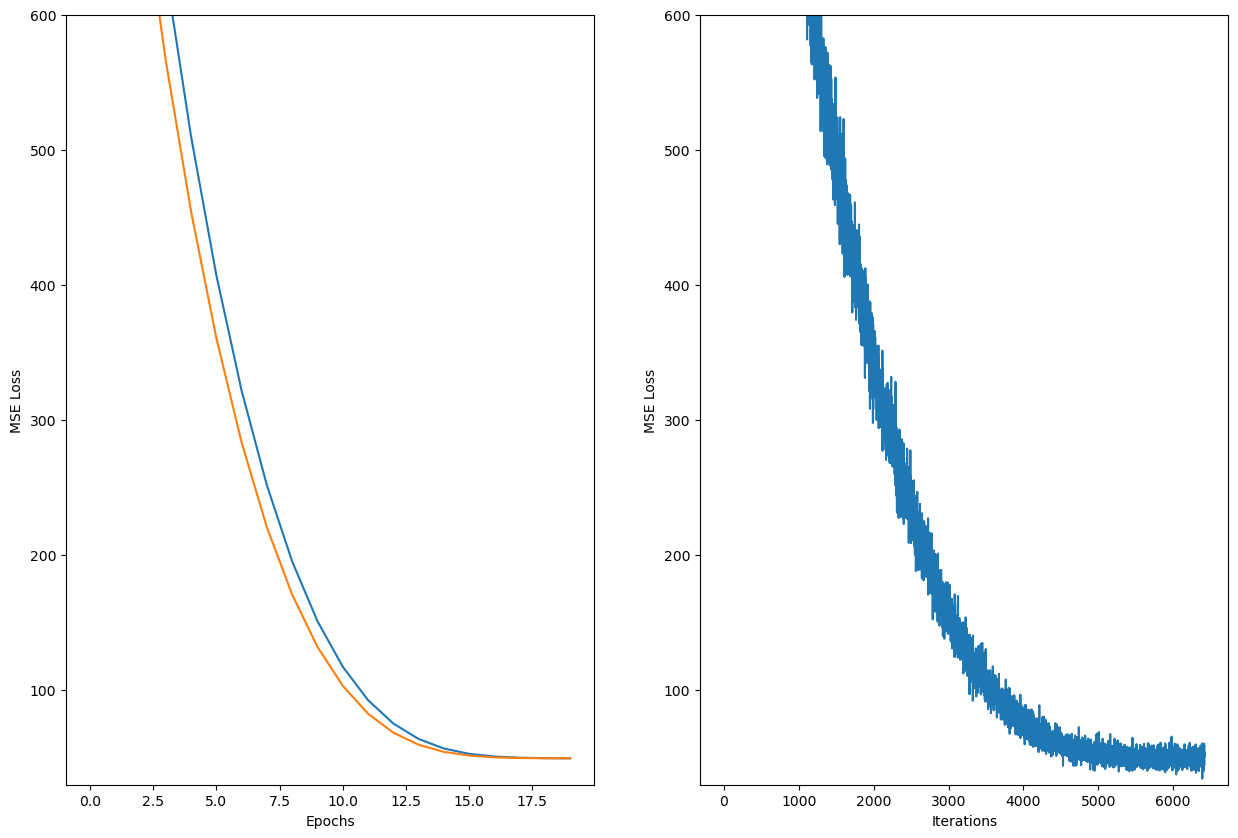

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,10))
axes[0].plot(range(N_epochs), losses, label='Train Loss')
axes[0].plot(range(N_epochs), validate_losses, label = 'Validate Loss')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("MSE Loss")
axes[0].set_ylim(30, 600)

axes[1].plot(range(len(batch_loss_graph)), np.array(batch_loss_graph).squeeze(), label = 'Losses for each iteration')
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE Loss")
axes[1].set_ylim(30, 600)